In [46]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib.image as mpimg

sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python')
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')

In [47]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math   

HTML("""
<style>
.output_png{
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

figsize(16,8)

In [48]:
warnings.filterwarnings("ignore", category=SyntaxWarning)
import lumapi
emeApi = lumapi.MODE()

Units

In [49]:
um = 1e-6
nm = 1e-9

Device parameters

In [50]:
#inverse tapers
taper_length      = 5*um
taper_larger_tip  = 2*um
taper_smaller_tip = 0.5*um


#wire waveguide
wg_length = 2*um
wg_width  = 0.5*um

wg_length2 = 3*um
wg_width2  = 2*um
#general
height = 220*nm

Materials

In [51]:
materialClad = "SiO2 (Glass) - Palik"
materialSi = "Si (Silicon) - Palik"

In [52]:
emeApi.switchtolayout()
emeApi.deleteall()
emeApi.cleardcard()

In [53]:
emeApi.addstructuregroup()
dev_layer = 'GDS_LAYER_35:4'
emeApi.set('name', dev_layer)

Taper

 $z′ = \frac{(z−z0)}{(z1−z0)}$
 
$f(z') = z'$

Where z0 is the starting point and z1 is the ending point


In [54]:
x0 = 0
x1 = taper_length
y0 = taper_larger_tip/2
y1 = taper_smaller_tip/2

x = np.linspace(taper_length, 0, 100)
alpha = (x-x0)/(x1-x0)
equation = y0 + alpha * (y1-y0)
upper = np.column_stack((x,equation))
lower = np.column_stack((x[::-1], -equation[::-1]))
taper = np.vstack((upper, lower))

In [55]:
emeApi.addpoly()
emeApi.addtogroup(dev_layer)

In [56]:
emeApi.set('name', 'taper')
emeApi.set('vertices', taper)   
emeApi.set('x', 0)
emeApi.set('y', 0)
emeApi.set('z', height/2)
emeApi.set('z span', height)
emeApi.set('material', materialSi)

    Wire waveguide

In [57]:
emeApi.addrect()
emeApi.addtogroup(dev_layer)
emeApi.set('name', 'wire waveguide')
emeApi.set('x', taper_length + wg_length/2)
emeApi.set('x span', wg_length)
emeApi.set('y', 0)
emeApi.set('y span', wg_width)
emeApi.set('z', height/2)
emeApi.set('z span', height)
emeApi.set('material', materialSi)

left wave guide

In [58]:
emeApi.addrect()
emeApi.addtogroup(dev_layer)
emeApi.set('name', 'wire waveguide 2')
emeApi.set('x', -wg_length2/2)
emeApi.set('x span', wg_length2)
emeApi.set('y', 0)
emeApi.set('y span', wg_width2)
emeApi.set('z', height/2)
emeApi.set('z span', height)
emeApi.set('material', materialSi)

Analysis    

In [59]:
mesh_cells = 200
emeApi.addeme()

In [60]:
emeApi.switchtolayout()
emeApi.set('x', 0)
emeApi.set('x min', emeApi.getnamed(f'{dev_layer}::wire waveguide 2', 'x min'))
emeApi.set('y', 0)
emeApi.set('y span', taper_larger_tip*1.5)
emeApi.set('z', height/2)
emeApi.set('z span', height*1.5) 
emeApi.set('background material', materialClad)
emeApi.set('mesh cells y', mesh_cells)
emeApi.set('mesh cells z', mesh_cells)

In [61]:
cell_wgd = 1
cell_taper = 15
cell_wgd2 = 1

method_wgd   = 0
method_taper = 1

modes_wgd1   = 20
modes_taper = 20
modes_wgd2   = 5

emeApi.set('number of cell groups', 3) #waveguide -> taper -> waveguide
emeApi.set('group spans', np.block([[wg_length2], [taper_length], [wg_length]]))
emeApi.set('cells', np.block([[cell_wgd], [cell_taper], [cell_wgd2]]))
emeApi.set('subcell method', np.block([[method_wgd], [method_taper], [method_wgd]]))
emeApi.set('allow custom eigensolver settings', True)
emeApi.set('modes', np.block([[modes_wgd1], [modes_taper], [modes_wgd2]]))
emeApi.set('display cells', 1)

#emeApi.set('min mesh step', 5e-10)

#boundary conditions
emeApi.set('y min bc', 'Metal')
emeApi.set('y max bc', 'Metal')
emeApi.set('z min bc', 'Metal')
emeApi.set('z max bc', 'Metal')

In [62]:
emeApi.addemeprofile()
emeApi.set('name', 'profile')
emeApi.set('monitor type', 3)
emeApi.set('x', 2*um)
emeApi.set('x span', emeApi.getnamed('EME', 'x span'))
emeApi.set('y',0)
emeApi.set('y span', taper_larger_tip*1.5)
emeApi.set('z', height/2)

simulation

In [63]:
emeApi.save('lineartaperEME')
emeApi.run()

In [64]:
emeApi.emepropagate()

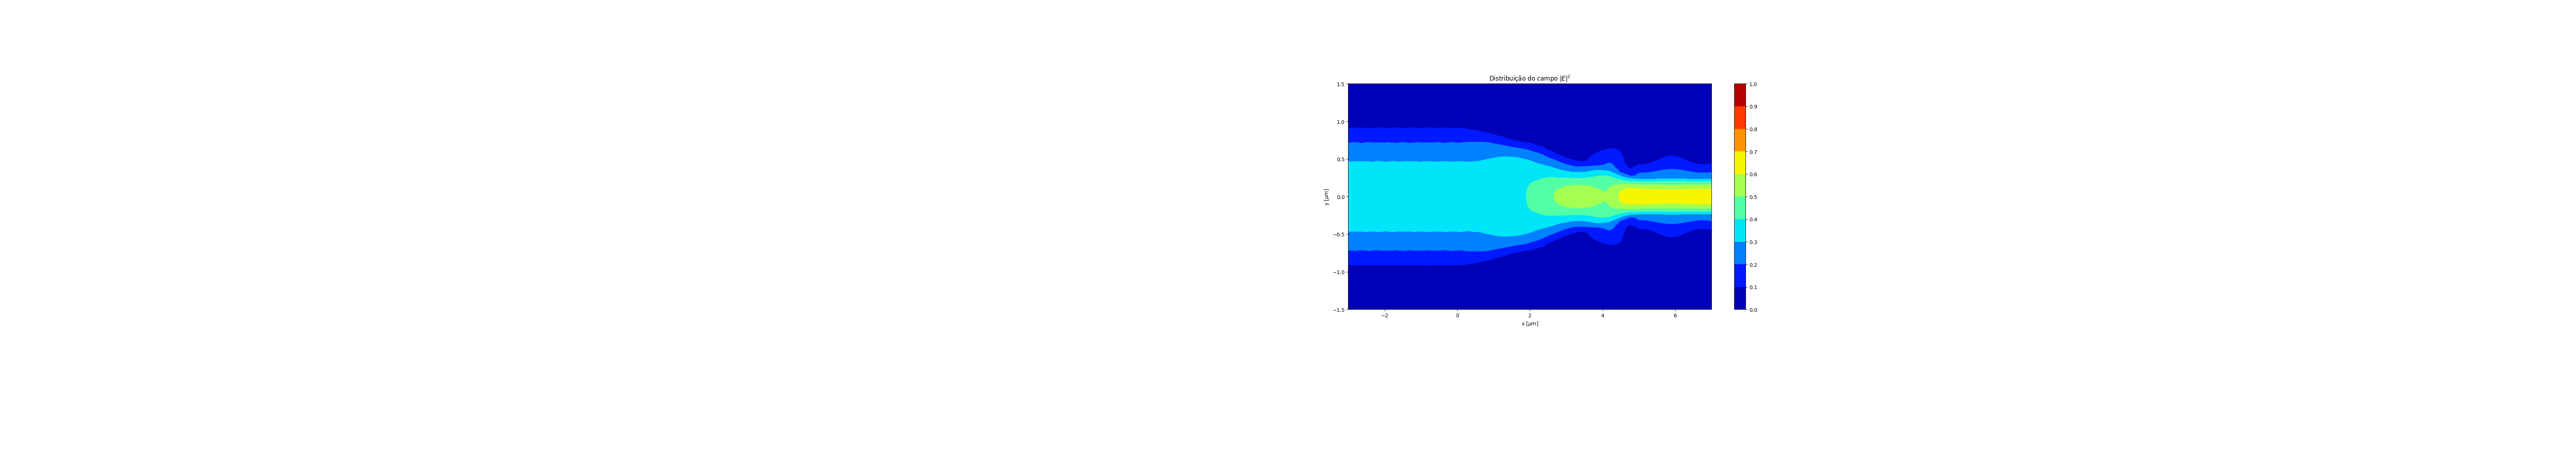

In [65]:
#field profile
E = emeApi.getresult('profile', 'field profile')

x = E['x']
x = x[:, 0] / um
y = E['y']
y = y[:, 0] / um
z = E['z']

E = E['E']

Ex = E[:, :, 0, :, 0]
Ey = E[:, :, 0, :, 1]
Ez = E[:, :, 0, :, 2]

Emag = np.sqrt(np.abs(Ex) ** 2 + np.abs(Ey) ** 2 + np.abs(Ez) ** 2)
plt.figure()
mycmap = plt.get_cmap('jet')

v = np.linspace(0, 1, 11, endpoint=True)

plt.contourf(x, y, np.transpose(Emag[:, :, 0]), v, cmap=mycmap)
plt.colorbar(ticks=v)
plt.title(r'Distribuição do campo $|E|^2$', fontsize=12)
plt.ylabel(r'y $[\mu m]$', fontsize=10)
plt.xlabel(r'x $[\mu m]$', fontsize=10)

plt.text(-40, 2.5, 'Porta 1', fontsize=12, fontweight='bold', color='w')
plt.text(-40, -3.5, 'Porta 4', fontsize=12, fontweight='bold', color='w')
plt.text(30, 2.5, 'Porta 2', fontsize=12, fontweight='bold', color='w')
plt.text(30, -3.5, 'Porta 3', fontsize=12, fontweight='bold', color='w')
plt.savefig('Distribuição do campo E - linear')

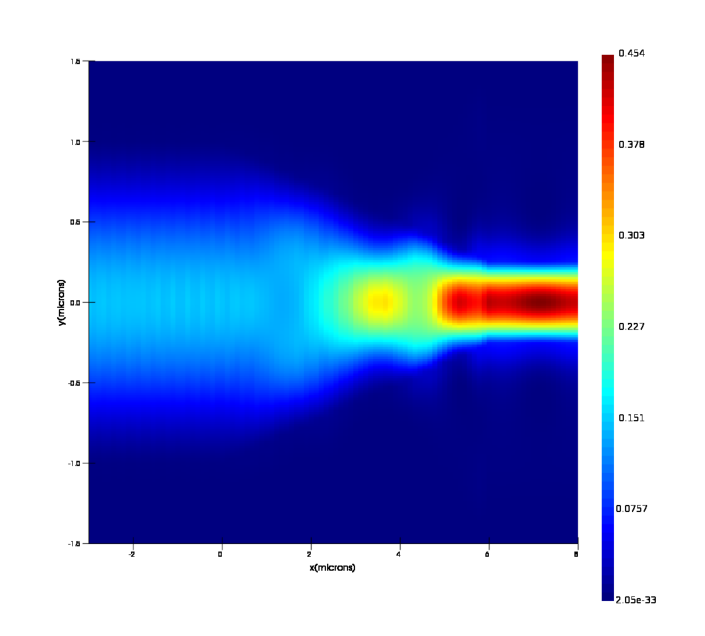

In [66]:
img = mpimg.imread('perfil linear.png')
plt.imshow(img)
plt.axis('off') 
plt.show()

In [67]:
interval = 0.1
emeApi.setemeanalysis('propagation sweep', 1)
emeApi.setemeanalysis('parameter', 'group span 2')
emeApi.setemeanalysis('start',1*um)
emeApi.setemeanalysis('stop', 6*um)
emeApi.setemeanalysis('interval', interval)
emeApi.emesweep('propagation sweep')
S = emeApi.getemesweep('S')
group_span = S['group_span_2']


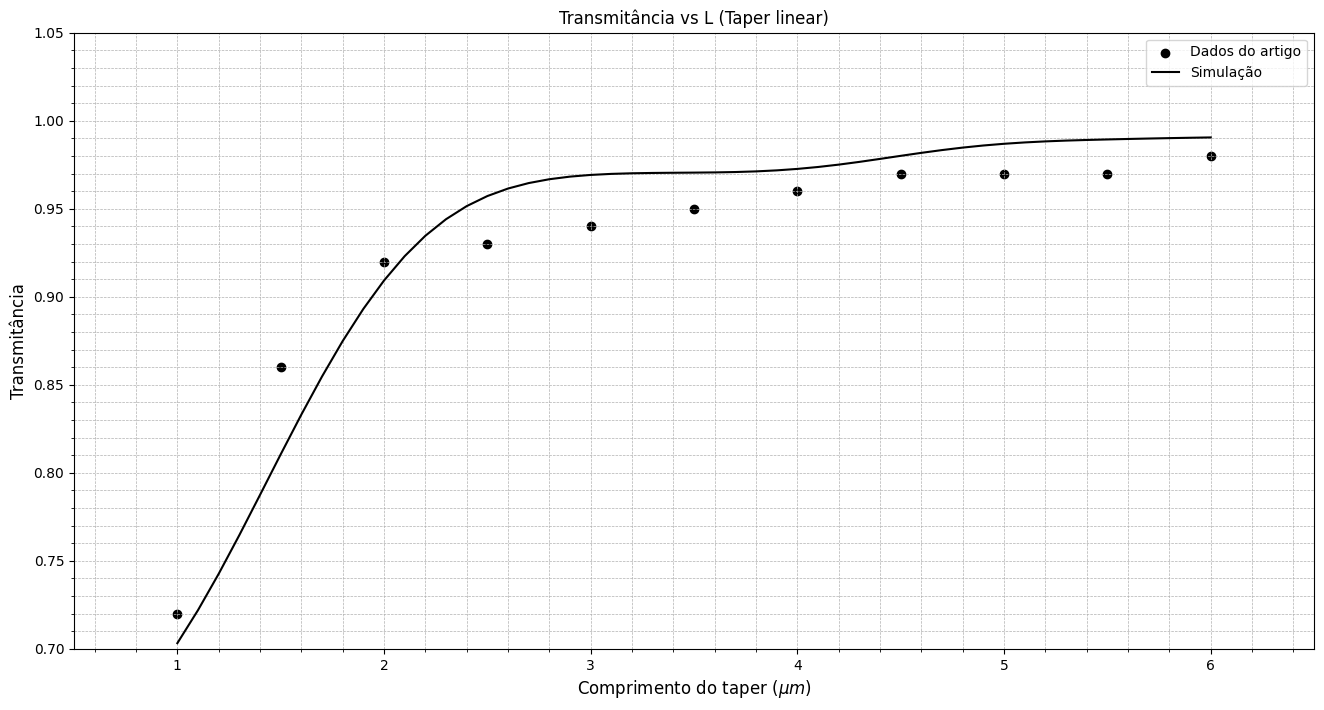

In [68]:
x_article = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]
y_article = [0.72, 0.86, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.97, 0.97, 0.98]
T = np.abs(S['s21'])**2
plt.scatter(x_article, y_article, color='black', label='Dados do artigo')
plt.plot(group_span/um, T, 'black', lw=1.5, label='Simulação')
plt.xlabel(r'Comprimento do taper $(\mu m)$', fontsize = 12)
plt.ylabel('Transmitância', fontsize = 12)
plt.xlim(0.5, 6.5)
plt.ylim([0.7,1.05])
plt.legend()
plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.title(r'Transmitância vs L (Taper linear)')
plt.grid(True)
plt.savefig('Tlinear')

In [69]:
emeApi.switchtolayout()
emeApi.select(f'{dev_layer}::taper')
emeApi.delete()

In [70]:
#wire waveguide
x0 = 0
x1 = taper_length
y0 = taper_larger_tip / 2
y1 = taper_smaller_tip / 2

x = np.linspace(taper_length, 0, 50)
g = np.log(taper_smaller_tip / taper_larger_tip)
alpha_exp = (np.exp(g * x / taper_length) - 1) / (np.exp(g) - 1)
equation = y0 + alpha_exp * (y1 - y0)
upper = np.column_stack((x, equation))
lower = np.column_stack((x[::-1], -equation[::-1]))
taper = np.vstack((upper, lower))

emeApi.addpoly()
emeApi.addtogroup(dev_layer)

emeApi.set('name', 'taper')
emeApi.set('vertices', taper)
emeApi.set('x', 0)
emeApi.set('y', 0)
emeApi.set('z', height / 2)
emeApi.set('z span', height)
emeApi.set('material', materialSi)

In [71]:
emeApi.switchtolayout()
emeApi.select('EME')
emeApi.set('x', 0)
emeApi.set('x min', emeApi.getnamed(f'{dev_layer}::wire waveguide 2', 'x min'))
emeApi.set('y', 0)
emeApi.set('y span', taper_larger_tip * 1.5)
emeApi.set('z', height / 2)
emeApi.set('z span', height * 1.5)
emeApi.set('background material', materialClad)
emeApi.set('mesh cells y', mesh_cells)
emeApi.set('mesh cells z', mesh_cells)

In [72]:
cell_wgd = 1
cell_taper = 21  
cell_wgd2 = 1

method_wgd = 0
method_taper = 1

modes_wgd1 = 20
modes_taper = 20
modes_wgd2 = 5

emeApi.set('number of cell groups', 3)  #waveguide -> taper -> waveguide
emeApi.set('group spans', np.block([[wg_length2], [taper_length], [wg_length]]))
emeApi.set('cells', np.block([[cell_wgd], [cell_taper], [cell_wgd2]]))
emeApi.set('subcell method', np.block([[method_wgd], [method_taper], [method_wgd]]))
emeApi.set('allow custom eigensolver settings', True)
emeApi.set('modes', np.block([[modes_wgd1], [modes_taper], [modes_wgd2]]))
emeApi.set('display cells', 1)
#boundary conditions
emeApi.set('y min bc', 'Metal')
emeApi.set('y max bc', 'Metal')
emeApi.set('z min bc', 'Metal')
emeApi.set('z max bc', 'Metal')

In [73]:
emeApi.save('exponentialtaperEME')
emeApi.run()


In [74]:
emeApi.emepropagate()

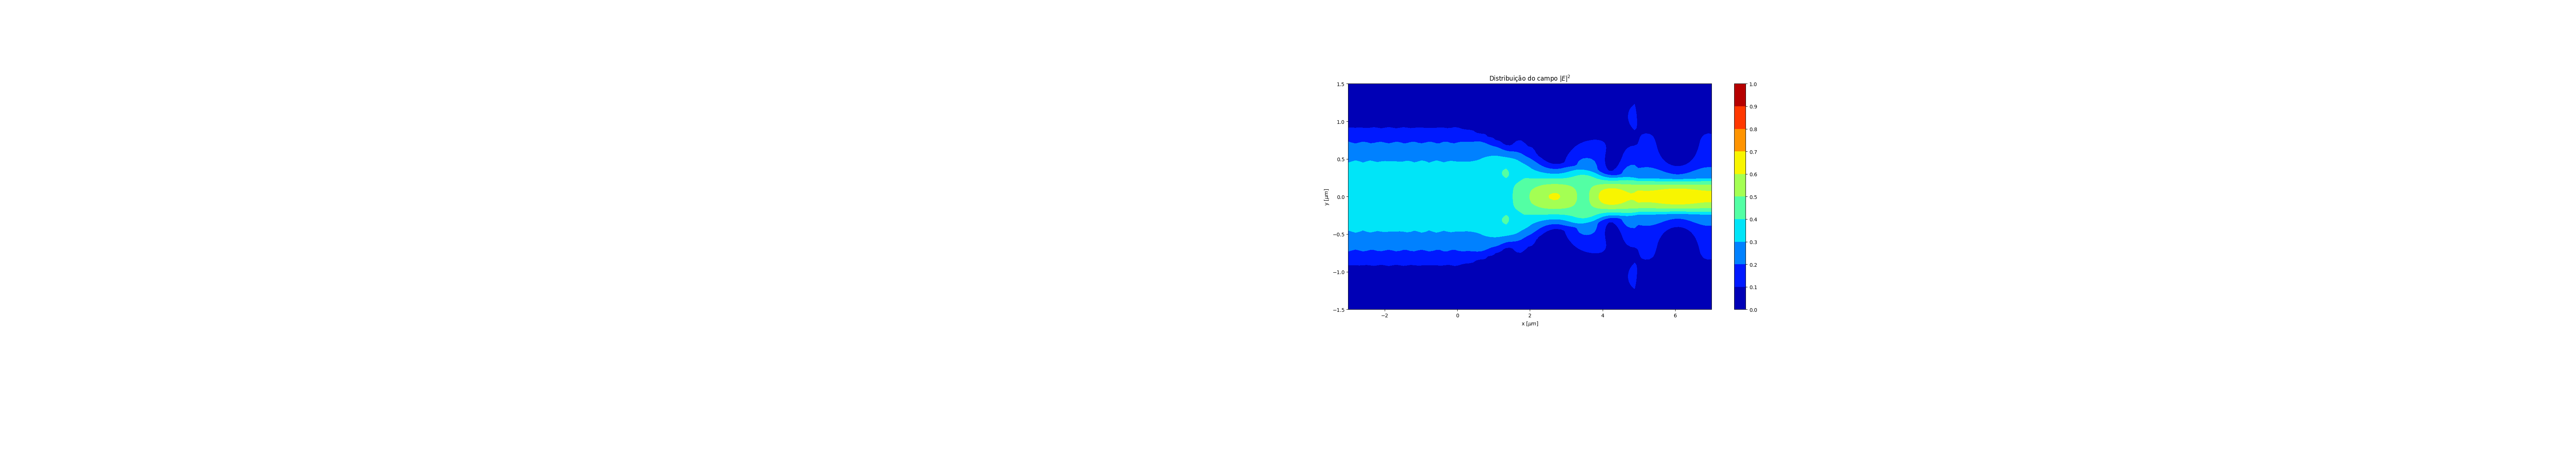

In [75]:
#field profile
E = emeApi.getresult('profile', 'field profile')

x = E['x']
x = x[:, 0] / um
y = E['y']
y = y[:, 0] / um
z = E['z']

E = E['E']

Ex = E[:, :, 0, :, 0]
Ey = E[:, :, 0, :, 1]
Ez = E[:, :, 0, :, 2]

Emag = np.sqrt(np.abs(Ex) ** 2 + np.abs(Ey) ** 2 + np.abs(Ez) ** 2)
plt.figure()
mycmap = plt.get_cmap('jet')

v = np.linspace(0, 1, 11, endpoint=True)

plt.contourf(x, y, np.transpose(Emag[:, :, 0]), v, cmap=mycmap)
plt.colorbar(ticks=v)
plt.title(r'Distribuição do campo $|E|^2$', fontsize=12)
plt.ylabel(r'y $[\mu m]$', fontsize=10)
plt.xlabel(r'x $[\mu m]$', fontsize=10)

plt.text(-40, 2.5, 'Porta 1', fontsize=12, fontweight='bold', color='w')
plt.text(-40, -3.5, 'Porta 4', fontsize=12, fontweight='bold', color='w')
plt.text(30, 2.5, 'Porta 2', fontsize=12, fontweight='bold', color='w')
plt.text(30, -3.5, 'Porta 3', fontsize=12, fontweight='bold', color='w')
plt.savefig('Distribuição do campo E - exponencial')


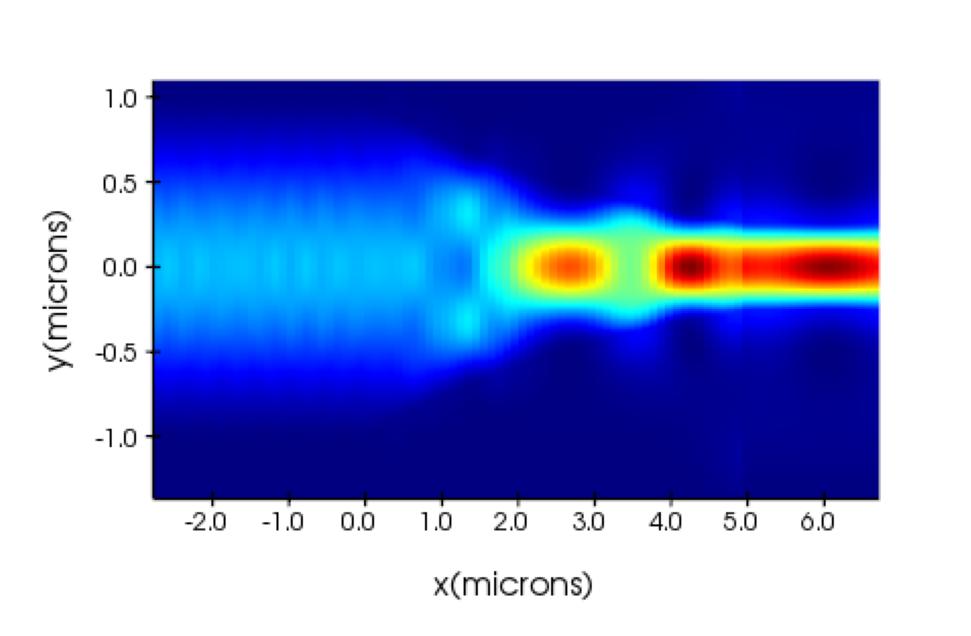

In [76]:
img2 = mpimg.imread('perfil exponencial.png')
plt.imshow(img2)
plt.axis('off') 
plt.show()

In [77]:
interval = 0.1
emeApi.setemeanalysis('propagation sweep', 1)
emeApi.setemeanalysis('parameter', 'group span 2')
emeApi.setemeanalysis('start', 1 * um)
emeApi.setemeanalysis('stop', 6 * um)
emeApi.setemeanalysis('interval', interval)
emeApi.emesweep('propagation sweep')
S = emeApi.getemesweep('S')
group_span = S['group_span_2']


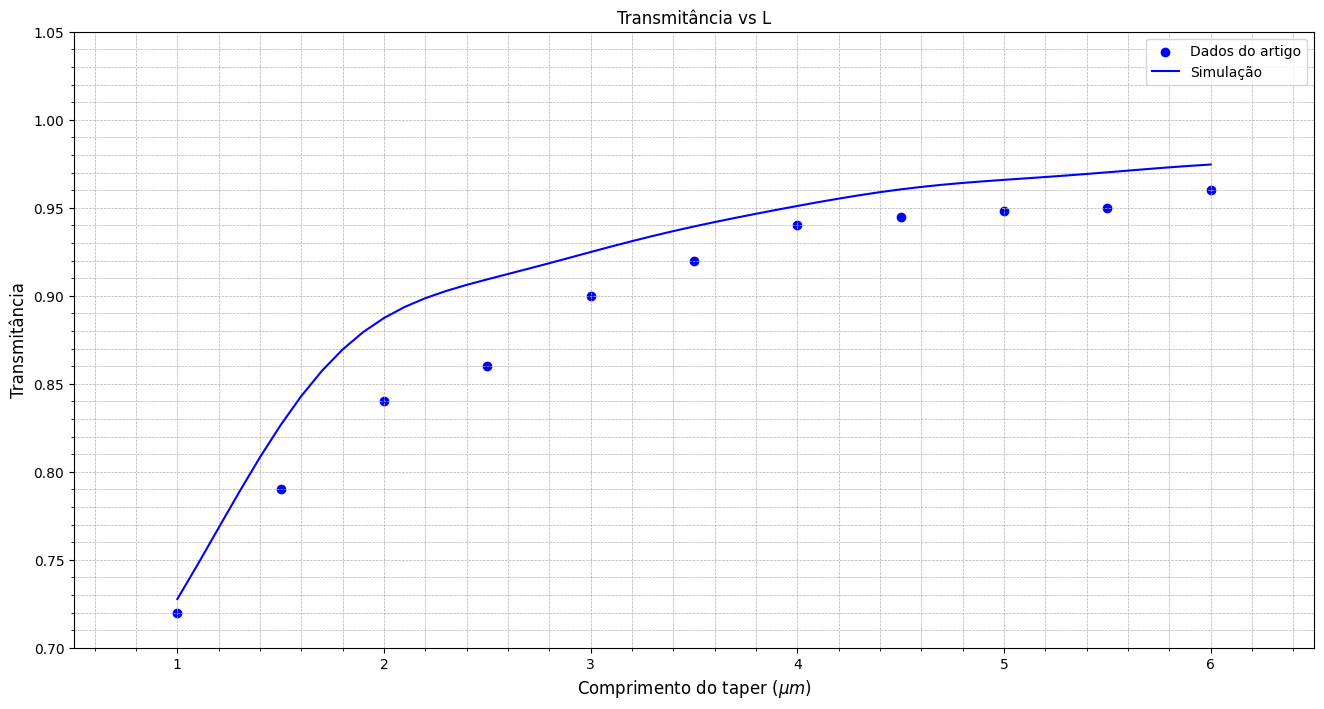

In [78]:
x_article = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]
y_article_exp = [0.72, 0.79, 0.84, 0.86, 0.90, 0.92, 0.94, 0.945, 0.948, 0.95, 0.96]
T1 = np.abs(S['s21']) ** 2
plt.scatter(x_article, y_article_exp, color='blue', label='Dados do artigo')
plt.plot(group_span / um, T1, 'blue', lw=1.5, label='Simulação')
plt.xlabel(r'Comprimento do taper $(\mu m)$', fontsize=12)
plt.ylabel('Transmitância', fontsize=12)
plt.xlim(0.5, 6.5)
plt.ylim([0.7,1.05])
plt.legend()
plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.title(r'Transmitância vs L')
plt.grid(True)
plt.savefig('T_exp')

In [79]:
emeApi.switchtolayout()
emeApi.select(f'{dev_layer}::taper')
emeApi.delete()

In [80]:
x0 = 0
x1 = taper_length
y0 = taper_larger_tip / 2
y1 = taper_smaller_tip / 2

x = np.linspace( 0,taper_length, 100)

alpha_quad = ((x -x0)/ (x1 - x0))**2
equation = y0 + alpha_quad * (y1 - y0)

upper = np.column_stack((x, equation))
lower = np.column_stack((x[::-1], -equation[::-1]))
taper = np.vstack((upper, lower))

In [81]:
emeApi.addpoly()
emeApi.addtogroup(dev_layer)
emeApi.set('name', 'taper')
emeApi.set('vertices', taper)
emeApi.set('x', 0)
emeApi.set('y', 0)
emeApi.set('z', height / 2)
emeApi.set('z span', height)
emeApi.set('material', materialSi)

In [82]:
emeApi.switchtolayout()
emeApi.select('EME')
emeApi.set('x', 0)
emeApi.set('x min', emeApi.getnamed(f'{dev_layer}::wire waveguide 2', 'x min'))
emeApi.set('y', 0)
emeApi.set('y span', taper_larger_tip * 1.5)
emeApi.set('z', height / 2)
emeApi.set('z span', height * 1.5)
emeApi.set('background material', materialClad)
emeApi.set('mesh cells y', mesh_cells)
emeApi.set('mesh cells z', mesh_cells)
cell_wgd = 1
cell_taper = 4
cell_wgd2 = 1

method_wgd = 0
method_taper = 1

modes_wgd1 = 20
modes_taper = 20
modes_wgd2 = 5

emeApi.set('number of cell groups', 3)  #waveguide -> taper -> waveguide
emeApi.set('group spans', np.block([[wg_length2], [taper_length], [wg_length]]))
emeApi.set('cells', np.block([[cell_wgd], [cell_taper], [cell_wgd2]]))
emeApi.set('subcell method', np.block([[method_wgd], [method_taper], [method_wgd]]))
emeApi.set('allow custom eigensolver settings', True)
emeApi.set('modes', np.block([[modes_wgd1], [modes_taper], [modes_wgd2]]))
emeApi.set('display cells', 1)

#emeApi.set('min mesh step', 5e-10)

#boundary conditions
emeApi.set('y min bc', 'Metal')
emeApi.set('y max bc', 'Metal')
emeApi.set('z min bc', 'Metal')
emeApi.set('z max bc', 'Metal')

In [83]:
emeApi.save('parabolictaperEME')
emeApi.run()


In [84]:
emeApi.emepropagate()

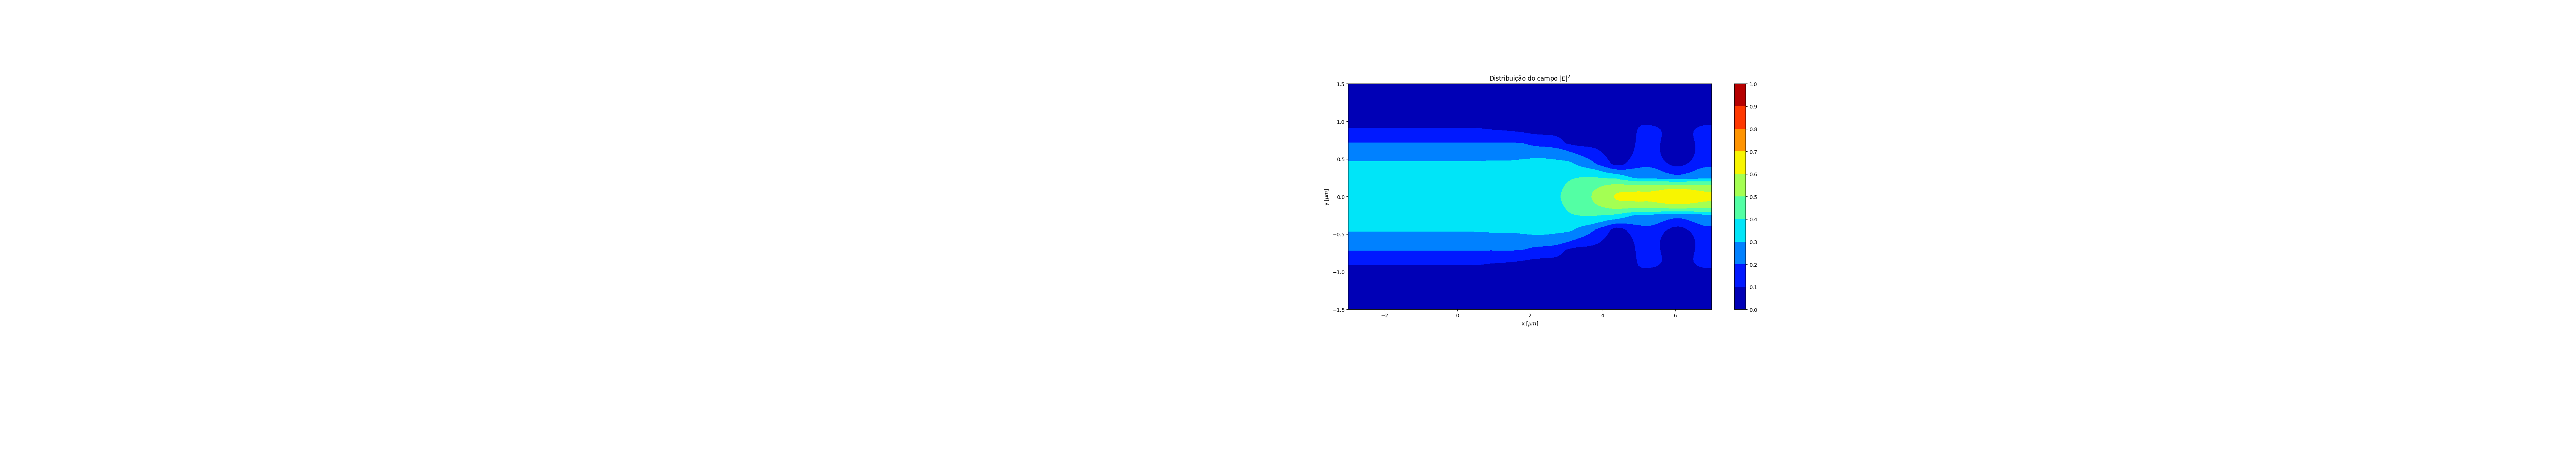

In [85]:
#field profile
E = emeApi.getresult('profile', 'field profile')

x = E['x']
x = x[:, 0] / um
y = E['y']
y = y[:, 0] / um
z = E['z']

E = E['E']

Ex = E[:, :, 0, :, 0]
Ey = E[:, :, 0, :, 1]
Ez = E[:, :, 0, :, 2]

Emag = np.sqrt(np.abs(Ex) ** 2 + np.abs(Ey) ** 2 + np.abs(Ez) ** 2)
plt.figure()
mycmap = plt.get_cmap('jet')

v = np.linspace(0, 1, 11, endpoint=True)

plt.contourf(x, y, np.transpose(Emag[:, :, 0]), v, cmap=mycmap)
plt.colorbar(ticks=v)
plt.title(r'Distribuição do campo $|E|^2$', fontsize=12)
plt.ylabel(r'y $[\mu m]$', fontsize=10)
plt.xlabel(r'x $[\mu m]$', fontsize=10)

plt.text(-40, 2.5, 'Porta 1', fontsize=12, fontweight='bold', color='w')
plt.text(-40, -3.5, 'Porta 4', fontsize=12, fontweight='bold', color='w')
plt.text(30, 2.5, 'Porta 2', fontsize=12, fontweight='bold', color='w')
plt.text(30, -3.5, 'Porta 3', fontsize=12, fontweight='bold', color='w')
plt.savefig('Distribuição do campo E - exponencial')


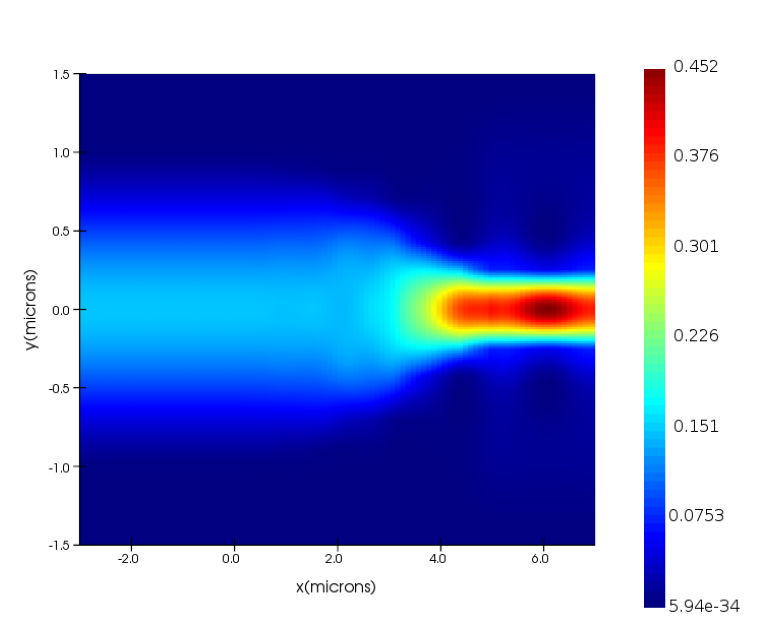

In [86]:
img3 = mpimg.imread('perfil parabolico.png')
plt.imshow(img3)
plt.axis('off') 
plt.show()

In [87]:
interval = 0.1
emeApi.setemeanalysis('propagation sweep', 1)
emeApi.setemeanalysis('parameter', 'group span 2')
emeApi.setemeanalysis('start', 1 * um)
emeApi.setemeanalysis('stop', 6 * um)
emeApi.setemeanalysis('interval', interval)
emeApi.emesweep('propagation sweep')
S = emeApi.getemesweep('S')
group_span = S['group_span_2']


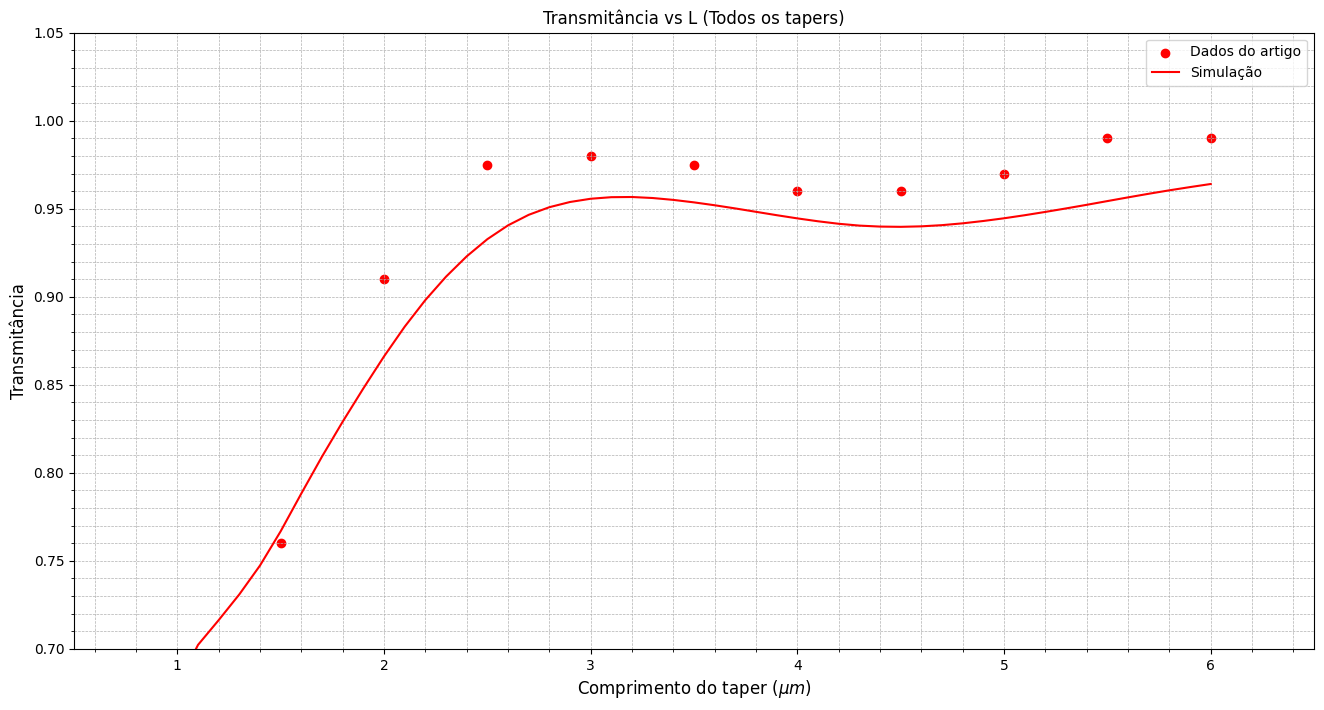

In [88]:
x_article = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]
y_article_q = [0.6,0.76, 0.91, 0.975, 0.98, 0.975, 0.96, 0.96, 0.97, 0.99,0.99]

T2 = np.abs(S['s21']) ** 2
plt.scatter(x_article, y_article_q, color='red', label='Dados do artigo')
plt.plot(group_span / um, T2, 'red', lw=1.5, label='Simulação')

plt.xlabel(r'Comprimento do taper $(\mu m)$', fontsize=12)
plt.ylabel('Transmitância', fontsize=12)
plt.xlim(0.5, 6.5)
plt.ylim([0.7,1.05])
plt.legend()
plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.title(r'Transmitância vs L (Todos os tapers)')
plt.grid(True)
plt.savefig('T_parabolico')

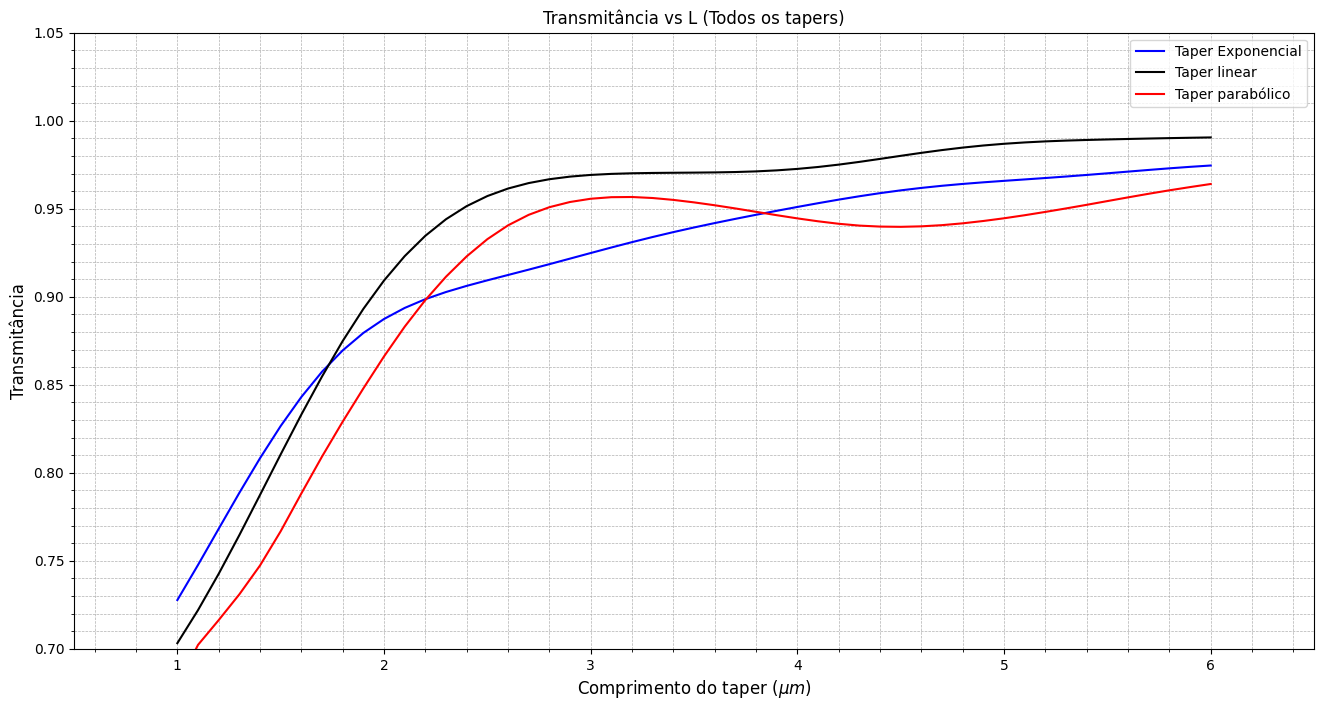

In [89]:
T2 = np.abs(S['s21']) ** 2
plt.plot(group_span / um, T1, 'blue', lw=1.5, label='Taper Exponencial')
plt.plot(group_span/um, T, 'black', lw=1.5, label='Taper linear')
plt.plot(group_span / um, T2, 'red', lw=1.5, label='Taper parabólico')

plt.xlabel(r'Comprimento do taper $(\mu m)$', fontsize=12)
plt.ylabel('Transmitância', fontsize=12)
plt.xlim(0.5, 6.5)
plt.ylim([0.7,1.05])
plt.legend()
plt.grid(which='both', axis='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()
plt.title(r'Transmitância vs L (Todos os tapers)')
plt.grid(True)
plt.savefig('T_all')

In [90]:
emeApi.switchtolayout()
emeApi.close()